## Imports and global parameters

In [78]:
import logging
logging.getLogger('tensorflow').setLevel(logging.FATAL)

In [79]:
import tensorflow as tf
import tensorflow_hub as hub
import keras
import optuna
import numpy as np
import sklearn as sk
import matplotlib.pyplot as plt
import plotly
import time
import pandas as pd
import os
import sys
import random
import math
import logging
from sklearn.model_selection import train_test_split, KFold
from keras import layers
from optuna.visualization import plot_slice

In [80]:
!mkdir -p models

gpus = tf.config.experimental.list_physical_devices('GPU')
print(gpus)

if len(gpus) > 0:
    tf.config.experimental.set_memory_growth(gpus[0], True)

[]


In [81]:
IMG_PATH = 'data/img/'
AUTO = tf.data.AUTOTUNE
BATCH_SIZE = 64
IM_SHAPE = (500,500, 3)
MAX_EPOCHS = 40
MODEL_SELECTION_STEPS = 50

BACKBONE_MODEL = 'efficientnet'

# Data preprocessing

### Read csv files and create datasets

In [82]:
df = pd.read_csv('data/data.csv')
df['id'] = df['id'].apply(lambda id: os.path.join(IMG_PATH, id))
df.rotErr.quantile(.99)

0.04335412000000012

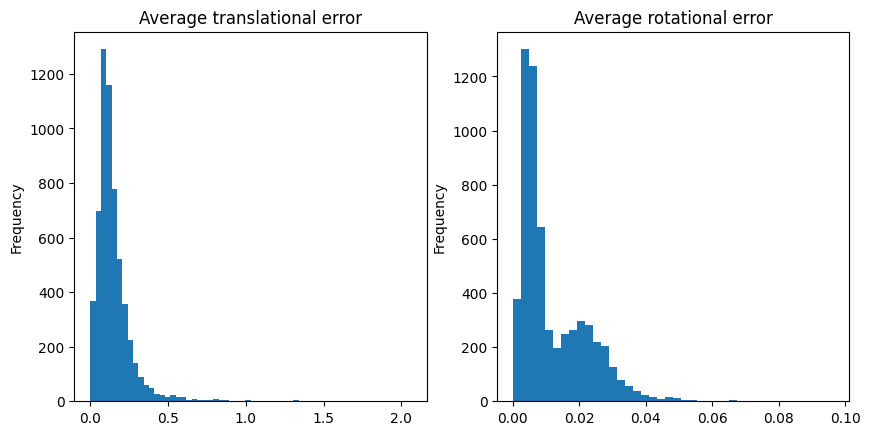

In [83]:
fig, ax = plt.subplots(1, 2)
fig.set_figwidth(10)
df['translErr'].plot.hist(bins=60, title='Average translational error', ax=ax[0])
df['rotErr'].plot.hist(bins=40, title='Average rotational error', ax=ax[1])
plt.show()

#### Feature Clipping
To perform data rescaling, every value that is above $k = 99th\ percentile$ is clipped to $k$.

In [84]:
rot = df['rotErr'].copy()
rot[rot > rot.quantile(.995)] = rot.quantile(.995)
df['rotErr'] = rot

transl = df['translErr'].copy()
transl[transl > transl.quantile(.995)] = transl.quantile(.995)
df['translErr'] = transl


#### Data rescaling

In [85]:
# TODO: ragiona bene su scaling + clipping dei dati
rescaler_rot = sk.preprocessing.MinMaxScaler()
rescaler_transl = sk.preprocessing.MinMaxScaler()
df['rotErr'] = rescaler_rot.fit_transform(df['rotErr'].values.reshape(-1,1)).squeeze()
df['translErr'] = rescaler_transl.fit_transform(df['translErr'].values.reshape(-1,1)).squeeze()
df['area'] /= df['area'].max()
df.head()

,id,translErr,rotErr,area
0,data/img/32-G5.png,0.651595,1.000000,0.097354
1,data/img/32-G7.png,0.777247,0.984398,0.193957
2,data/img/32-G9.png,0.546994,0.718890,0.101897
3,data/img/32-D8.png,0.614334,0.846781,0.147976
4,data/img/W31-2.png,0.263803,0.349292,0.081962


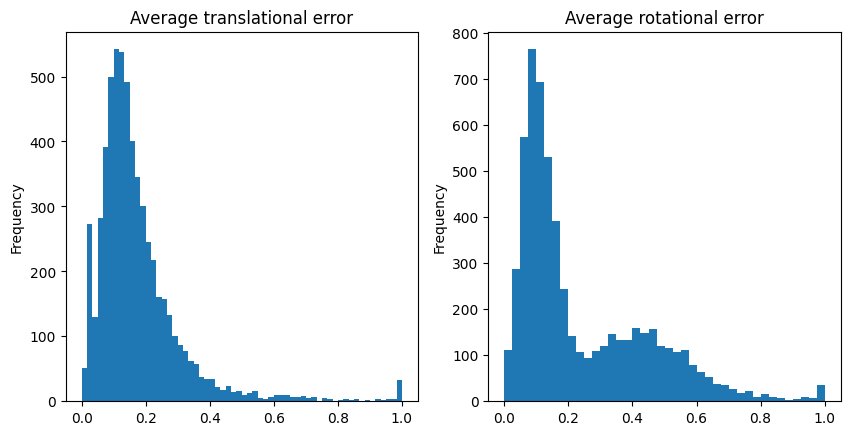

In [86]:
fig, ax = plt.subplots(1, 2)
fig.set_figwidth(10)
df['translErr'].plot.hist(bins=60, title='Average translational error', ax=ax[0])
df['rotErr'].plot.hist(bins=40, title='Average rotational error', ax=ax[1])
plt.show()

##### Data partitioning and dataset creation

In [87]:
train_df, test_df = train_test_split(df, test_size=0.3, random_state=42)
val_df, test_df = train_test_split(test_df, test_size=0.5, random_state=42)

In [88]:
def load_image(id: tf.types.experimental):
    image = tf.io.read_file(id)
    image = tf.image.decode_png(image)
    return image

def data_augmentation(img: np.ndarray):
    rotation = random.randint(0, 3)
    img = tf.image.rot90(img, k=rotation)
    img = tf.image.random_flip_up_down(img)
    img = tf.image.random_flip_left_right(img)
    return img


def load_dataset(df: pd.DataFrame, augment=False) -> tf.data.Dataset:
    X = tf.data.Dataset.from_tensor_slices(df["id"].values)
    area = tf.data.Dataset.from_tensor_slices(df["area"].values)
    Y = tf.data.Dataset.from_tensor_slices(df[["translErr", "rotErr"]].values)

    X = X.map(load_image, num_parallel_calls=AUTO)
    
    if augment:
        X = X.map(lambda img: data_augmentation(img), num_parallel_calls=AUTO)

    dataset = tf.data.Dataset.zip((X, area), Y)
    dataset = dataset.shuffle(500)
    dataset = dataset.batch(
        batch_size=BATCH_SIZE,
        num_parallel_calls=AUTO,
        deterministic=False,
        drop_remainder=False,
    )
    dataset = dataset.prefetch(AUTO)
    return dataset


train_data = load_dataset(train_df, augment=True)
val_data = load_dataset(val_df)
test_data = load_dataset(test_df)

In [89]:
train_data.take(1).get_single_element()

((<tf.Tensor: shape=(64, 500, 500, 1), dtype=uint8, numpy=
  array([[[[205],
           [205],
           [205],
           ...,
           [205],
           [205],
           [205]],
  
          [[205],
           [205],
           [205],
           ...,
           [205],
           [205],
           [205]],
  
          [[205],
           [205],
           [205],
           ...,
           [205],
           [205],
           [205]],
  
          ...,
  
          [[205],
           [205],
           [205],
           ...,
           [205],
           [205],
           [205]],
  
          [[205],
           [205],
           [205],
           ...,
           [205],
           [205],
           [205]],
  
          [[205],
           [205],
           [205],
           ...,
           [205],
           [205],
           [205]]],
  
  
         [[[205],
           [205],
           [205],
           ...,
           [205],
           [205],
           [205]],
  
          [[205],
     

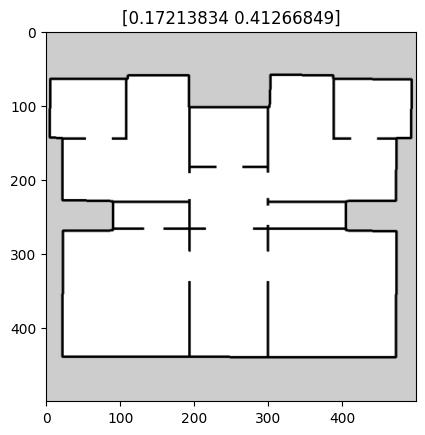

In [90]:
for r in val_data.take(1).as_numpy_iterator():
    r, l = r[0], r[1]
    plt.imshow(r[0][0], cmap='gray')
    plt.title(l[0])
    plt.show()
    break

In [91]:
def plot_history(hst: keras.callbacks.History):
    metrics = ["loss"]
    _, ax = plt.subplots(1, len(metrics), figsize=(15, 5))
    for _, metric in enumerate(metrics):
        ax.plot(hst.history[metric])
        ax.plot(hst.history["val_" + metric])
        ax.set(title="model " + metric, ylabel=metric, xlabel="epoch")
        ax.legend([metric, "val_" + metric], loc="upper left")
    plt.show()

## Define the CNN structure

In [92]:
def _build_efficientNet(input: layers.Layer):
    effNet = keras.applications.EfficientNetV2B3(include_top=False, pooling="avg")
    effNet.trainable = False
    return effNet(input)


def _build_mobileNet(input: layers.Layer):
    mobNet = keras.applications.MobileNetV3Large(include_top=False, pooling="avg")
    mobNet.trainable = False
    return mobNet(input)


def build_model(config: dict) -> keras.Model:  # EfficientNetV2B3
    backbone_builder = {
        "efficientnet": _build_efficientNet,
        "mobilenet": _build_mobileNet,
    }
    backbone = backbone_builder[BACKBONE_MODEL]

    input_layer = layers.Input(shape=IM_SHAPE, name='image_input')
    x = backbone(input_layer)

    # skip connection
    number_input = layers.Input(shape=(1,), name='number_input')
    x = layers.Concatenate()([number_input, x])

    for i in range(config["nLayers"]):
        x = layers.Dense(units=config[f"layer{i}_units"], name=f"dense_{i}")(x)
        if config["batchNorm"]:
            x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)

        if config["dropout"]:
            x = layers.Dropout(0.3)(x)

    out = layers.Dense(2, "relu", name="out_layer")(x)

    model = keras.Model(inputs=[input_layer, number_input], outputs=out, name=f"{BACKBONE_MODEL}_model")

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=config["lr"]), loss="mse"
    )
    return model

In [129]:
baselineHyperparameters = {
    "lr": 1e-4,
    "nLayers": 3,
    "batchNorm": True,
    "dropout": False,
    "layer0_units": 1024,
    "layer1_units": 512,
    "layer2_units": 128,
}
m = build_model(baselineHyperparameters)

# Sanity check to verify that dataset and model have been built correctly
m.fit(train_data.take(1), batch_size=BATCH_SIZE, epochs=1, validation_data=val_data.take(1))

1/1 [==============================] - 33s 33s/step - loss: 0.2347 - val_loss: 0.1786


### Hyperparameter tuning

In [48]:
def objective(trial: optuna.Trial) -> float:
    best_val_loss = np.inf
    patience = 0
    layerDim = [64, 128, 256, 512, 1024, 2048]
    config = {
        "lr": trial.suggest_float("lr", 1e-5, 1e-2, log=True),
        "nLayers": trial.suggest_int("nLayers", 1, 7),
        "batchNorm": trial.suggest_categorical("batchNorm", [True, False]),
        "dropout": trial.suggest_categorical("dropout", [True, False]),
        "layer0_units": trial.suggest_categorical("layer0_units", layerDim[-3:]),
    }
    n = config["nLayers"]
    for i in range(1, n):
        iMin, iMax = max(0, n - i - 3), max(n - i, 3)  # sliding window margins
        config[f"layer{i}units"] = trial.suggest_categorical(
            f"layer{i}_units", layerDim[iMin:iMax]
        )

    model = build_model(config)

    for train_step in range(MAX_EPOCHS):
        history = model.fit(train_data, batch_size=BATCH_SIZE, validation_data=val_data)
        val_loss = history.history["val_loss"][0]
        # Implement earlystopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience = 0
        else:
            patience += 1

        if patience > 5:
            break

        trial.report(val_loss, train_step)
        if trial.should_prune():
            raise optuna.TrialPruned()
    del model
    return best_val_loss

In [17]:
def kFoldCV(hyperPar: dict, training_set: pd.DataFrame, k: int) -> float:
    df = training_set.reset_index(drop=True)
    kf = KFold(n_splits=k, shuffle=True)
    scores = []
    for trainIdx, valIdx in kf.split(df):
        train_data = load_dataset(df.iloc[trainIdx], augment=True)
        val_data = load_dataset(df.iloc[valIdx])

        model = build_model(hyperPar)
        es = keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)
        model.fit(train_data, 
                  batch_size=BATCH_SIZE,
                  validation_data=val_data,
                  epochs=MAX_EPOCHS,
                  callbacks=[es]
                  )
        
        result = model.evaluate(val_data, batch_size=BATCH_SIZE)
        del model
        scores.append(result)
    return np.avg(scores)   # TODO: magari ritorna tutto l'array così calcoli varianza sui fold?

## Optimize EfficientNetV2

In [ ]:
optuna.logging.get_logger("optuna").addHandler(logging.StreamHandler(sys.stdout))
study = optuna.create_study(
    direction="minimize",
    sampler=optuna.samplers.TPESampler(),
    pruner=optuna.pruners.HyperbandPruner(),
    study_name='efficientNet_study'
)

study.enqueue_trial(baselineHyperparameters)    # Test on baseline parameters first and optimize from there
study.optimize(objective, n_trials=MODEL_SELECTION_STEPS, gc_after_trial=True)

In [ ]:
plot_slice(study)

In [23]:
study.best_params

In [ ]:
CV_loss_effNet = kFoldCV(study.best_params, train_df, 5)

In [ ]:
model = build_model(study.best_params)
es = keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)
model.fit(test_data, epochs=MAX_EPOCHS, batch_size=BATCH_SIZE, callbacks=[es])
model.save(f'models/efficientNet_model_{time.strftime("%d%b_%I_%M%p")}.keras')

test_loss_effNet = model.evaluate(test_data)

del model
keras.backend.clear_session()

In [ ]:
print(f'CV loss over training set: {CV_loss_effNet}\nLoss over the test set: {test_loss_effNet}')

## Optimize MobileNetV3_large

In [ ]:
BACKBONE_MODEL = 'mobilenet'

In [ ]:
study = optuna.create_study(
    direction="minimize",
    sampler=optuna.samplers.TPESampler(),
    pruner=optuna.pruners.HyperbandPruner(),
    study_name='mobileNet_study'
)

study.enqueue_trial(baselineHyperparameters)    # Test on baseline parameters first and optimize from there
study.optimize(objective, n_trials=MODEL_SELECTION_STEPS, gc_after_trial=True)

In [ ]:
plot_slice(study)

In [ ]:
study.best_params

In [ ]:
CV_loss_mobNet = kFoldCV(study.best_params, train_df, 5)

In [ ]:
model = build_model(study.best_params)
es = keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)
model.fit(test_data, epochs=MAX_EPOCHS, batch_size=BATCH_SIZE, callbacks=[es])
model.save(f'models/mobileNet_model_{time.strftime("%d%b_%I_%M%p")}.keras')

test_loss_mobNet = model.evaluate(test_data)

del model
keras.backend.clear_session()

In [ ]:
print(f'CV loss over training set: {CV_loss_mobNet}\nLoss over the test set: {test_loss_mobNet}')

## Experimenting with Vision Transformers

In [64]:
FINE_TUNE = False   #set to True to finetune the entire transformer

In [97]:
def build_ViT(config):
    VIT = hub.KerasLayer("https://www.kaggle.com/models/spsayakpaul/vision-transformer/TensorFlow2/vit-b16-fe/1")
    VIT.trainable = FINE_TUNE

    input_layer = layers.Input(shape=IM_SHAPE)
    number_input = layers.Input(shape=(1,), name='number_input')

    x = layers.Resizing(224,224)(input_layer)
    x = layers.Rescaling(1./127.5, offset=-1)(x)    # Rescaling to [-1, 1] as per ViT spec
    x = VIT(x)
    
    # skip connection
    x = layers.Concatenate()([number_input, x])
    
    x = layers.Dense(units=config['layer0_units'], activation='relu')(x)

    if config['dropout']:
        x = layers.Dropout(0.3)(x)

    out = layers.Dense(2, "relu", name="out_layer")(x)

    model = keras.Model(inputs=[input_layer, number_input], outputs=out, name=f"{BACKBONE_MODEL}_model")

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=config["lr"]), loss="mse"
    )
    return model

In [68]:
def objective_ViT(trial: optuna.Trial):
    best_val_loss = np.inf
    patience = 0
    config = {
        "lr": trial.suggest_float("lr", 1e-6, 1e-3, log=True),
        "dropout": trial.suggest_categorical("dropout", [True, False]),
        "layer0_units": trial.suggest_categorical("layer0_units", [64, 128, 256, 512]),
    }

    model = build_ViT(config)

    for train_step in range(MAX_EPOCHS):
        history = model.fit(train_data, batch_size=BATCH_SIZE, validation_data=val_data)
        val_loss = history.history["val_loss"][0]
        # Implement earlystopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience = 0
        else:
            patience += 1

        if patience > 5:
            break

        trial.report(val_loss, train_step)
        if trial.should_prune():
            raise optuna.TrialPruned()
    
    del model
    return best_val_loss

In [ ]:
baselineConfig = {
        "lr": 1e-4,
        "dropout": True,
        "layer0_units": 256,
    }

optuna.logging.get_logger("optuna").addHandler(logging.StreamHandler(sys.stdout))
study = optuna.create_study(
    direction="minimize",
    sampler=optuna.samplers.TPESampler(),
    pruner=optuna.pruners.HyperbandPruner(),
    study_name='ViT_study'
)

study.enqueue_trial(baselineConfig)    # Test on baseline parameters first and optimize from there
study.optimize(objective_ViT, n_trials=MODEL_SELECTION_STEPS, gc_after_trial=True)

In [24]:
plot_slice(study)

In [ ]:
study.best_params

In [23]:
model = build_ViT(study.best_params)
es = keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)
hst = model.fit(test_data, epochs=MAX_EPOCHS, batch_size=BATCH_SIZE, callbacks=[es])
model_name = f"ViT_model{'_finetuned' if FINE_TUNE else ''}_{time.strftime("%d%b_%I_%M%p")}"
model.save(f'models/{model_name}.keras')

test_loss_ViT = model.evaluate(test_data)

del model
keras.backend.clear_session()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 500, 500, 3)]     0         
                                                                 
 resizing_2 (Resizing)       (None, 224, 224, 3)       0         
                                                                 
 keras_layer (KerasLayer)    (None, 768)               85798656  
                                                                 
 dense (Dense)               (None, 1024)              787456    
                                                                 
 dense_1 (Dense)             (None, 256)               262400    
                                                                 
 dense_2 (Dense)             (None, 2)                 514       
                                                                 
Total params: 86849026 (331.30 MB)
Trainable params: 1050370 

In [ ]:
plot_history(hst)

In [ ]:
print(f"Vision transformer test loss: {test_loss_ViT}")